In [1]:
# code in this cell from:
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML("""
    <script>
        code_show = false
        function code_toggle() {
            if (code_show) {
                $("div.input").hide()
            }
            else {
                $("div.input").show()
            }
            code_show = !code_show
        }
        $(document).ready(code_toggle)
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>
""")

<div align="center" style="font-size: 2em">
Kickstarter ML Project - Predicting Campaign Success from Initial Characteristics
</div>

<div align="center" style="font-size: 1.25em">
by
</div>

<div align="center" style="font-size: 1.0em">
Jake Kroeker, Jeremiah McGrath, Christopher McMichael
</div>

# Setup

In [2]:
from datetime import datetime
from matplotlib import rcParams
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
sns.set()
rcParams['figure.figsize'] = 8,6

# Global Functions

In [3]:
def print_conf_matrix(y_correct, y_predict, labels):
    formatSize = 15 # Change this if your labels are long
    matrix = confusion_matrix(y_correct, y_predict)
    print('{:^{width}}'.format("Actual", width=str(formatSize*3)))
    print('{:^{width}}'.format("Predict", width=str(formatSize)), end='')
    print('{:^{width}}'.format(labels[0], width=str(formatSize)), end='')
    print('{:^{width}}'.format(labels[1], width=str(formatSize)))
    print('{:^{width}}'.format(labels[0], width=str(formatSize)), end='')
    print('{:^{width}}'.format(matrix[0,0], width=str(formatSize)), end='')
    print('{:^{width}}'.format(matrix[0,1], width=str(formatSize)))
    print('{:^{width}}'.format(labels[1], width=str(formatSize)), end='')
    print('{:^{width}}'.format(matrix[1,0], width=str(formatSize)), end='')
    print('{:^{width}}'.format(matrix[1,1], width=str(formatSize)))

    print_percent_correct(y_correct, y_predict)

def print_percent_correct(y_correct, y_predict):
    return (y_correct == y_predict).mean()

def roc_plot(X_test, label, clf):
    y_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Graph: {}'.format(label))
    plt.legend()
    plt.show()

# Preprocessing

In [4]:
# Read the data
df = pd.read_csv("ks-projects-201801.csv")

# Removing goal and USD pledged columns, they have some bad data
df = df.drop(columns=["goal", "usd pledged"], axis=1);

# Dropping some categories we don't need in our set
df = df.drop(columns=["name", "ID", "currency", "backers", "pledged", "usd_pledged_real"], axis=1)

# Removing all rows with a date less than 2000. The only ones that do are from 1970 (Unix start date)
df = df.drop(df[df["launched"] < "2000-00-00"].index);

# Removing all rows with an unusual "country" value
df = df[df['country'] != 'N,0"']

# Removing all rows with a state that is "undefined", "live", or "suspended"
df = df.drop(df[(df["state"] == "undefined") | (df["state"] == "live") | (df["state"] == "suspended")].index)

# Merging all rows with a state that is "canceled" into "failed"
df.loc[df["state"] == "canceled", "state"] = "failed"

# Converting the launched and deadline dates into actual dates
df["launched"] = pd.to_datetime(df["launched"])
df["deadline"] = pd.to_datetime(df["deadline"])
df["duration"] = df["deadline"] - df["launched"]
df["duration"] = df["duration"].dt.days

# Getting the time since unix values for launched and deadline
# Decision Trees need features to be an int
df["launchedUX"] = df["launched"].astype('int64')/ 10**9 / 60 / 60 / 24
df["deadlineUX"] = df["deadline"].astype('int64')/ 10**9 / 60 / 60 / 24

# Converting the state into a number
df["stateInt"] = (df['state'] == 'successful').values.astype(int)

# Creating a copy optimized for classification algorithms
clas_df = df.copy()
clas_df = clas_df.drop(["category", "main_category", "country", "state", "deadline", "launched"], axis=1)

# Creating datasets for main_category, category, and country
main_cat_dummies = pd.get_dummies(df["main_category"])
cat_dummies = pd.get_dummies(df["category"])
country_dummies = pd.get_dummies(df["country"])

# Data Summary

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370216 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   category       370216 non-null  object        
 1   main_category  370216 non-null  object        
 2   deadline       370216 non-null  datetime64[ns]
 3   launched       370216 non-null  datetime64[ns]
 4   state          370216 non-null  object        
 5   country        370216 non-null  object        
 6   usd_goal_real  370216 non-null  float64       
 7   duration       370216 non-null  int64         
 8   launchedUX     370216 non-null  float64       
 9   deadlineUX     370216 non-null  float64       
 10  stateInt       370216 non-null  int32         
dtypes: datetime64[ns](2), float64(3), int32(1), int64(1), object(4)
memory usage: 32.5+ MB


In [6]:
clas_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370216 entries, 0 to 378660
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   usd_goal_real  370216 non-null  float64
 1   duration       370216 non-null  int64  
 2   launchedUX     370216 non-null  float64
 3   deadlineUX     370216 non-null  float64
 4   stateInt       370216 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 15.5 MB


## Original Data Fields
1. ``ID`` - The internal ID of the Kickstarter project.
2. ``name`` - The project's name.
3. ``category`` - The project's specific category.
4. ``main_category`` - The project's overarching category.
5. ``currency`` - The currency used to support the project.
6. ``deadline`` - The project's deadline date.
7. ``goal`` - The project's fundraising goal in USD.
8. ``launched`` - The project's launch date.
9. ``pledged`` - The amount pledged in USD.
10. ``state`` - The project's state; options include "success", "failed", "cancelled".
11. ``backers`` - The number of backers.
12. ``country`` - The country the project was launched in.
13. ``usd pledged`` - The amount pledged in USD, converted by Kickstarter.
14. ``usd_pledged_real`` - The amount pledged in USD, converted using an external API.
15. ``usd_goal_real`` - The goal in USD, converted using an external API.

## Data Munging

#### Dropped Data Fields:
1. ``ID`` - Dropped due to being an internal Kickstarter value, irrelevant to our project.
2. ``name`` - Dropped due to not being useful for our classification models.
3. ``currency`` - Dropped due to not being useful for our classification models.
4. ``goal`` - Dropped due to having large amounts of bad data.
5. ``pledged`` - Dropped due to not aligning with our goal of being able to predict a campaign's success based off its initial characteristics.
6. ``backers`` - Dropped due to not aligning with our goal of being able to predict a campaign's success based off its initial characteristics.
7. ``usd pledged`` - Dropped due to not aligning with our goal of being able to predict a campaign's success based off its initial characteristics.
8. ``usd_pledged_real`` - Dropped due to not aligning with our goal of being able to predict a campaign's success based off its initial characteristics.

#### Altered Data Fields:
1. ``deadline`` - Converted to date-time values to aid in the calculation of time deltas.
2. ``launched``
    - Contained some invalid dates, notably those defined as the start of Unix time. Rows with years before 2000 were dropped due to being blatantly bad data samples – (Kickstarter was founded in 2009).
    - Converted to date-time values to aid in the calculation of time deltas.
6. ``country`` - Contained some unusual values, specifically ``'N,0"`` - (see: "Null Island"). Due to its infrequent occurrence, we chose to simply drop rows with this value from our dataset – about 3000 in total.
7. ``state``
    - Removed rows with states matching ``undefined``, ``live``, or ``suspended``, as these values represent campaigns that do not align with our analysis.
    - Transformed data points with the value ``canceled`` into ``failed``, as these states represent the same result for our analysis.

## Feature Engineering

#### Added Data Fields:
1. ``launchedUX`` - The time of the project's launch measured in days since Unix start - (January 1, 1970 at 00:00:00).
2. ``deadlineUX`` - The time of the project's deadline measured in days since Unix start - (January 1, 1970 at 00:00:00).
3. ``duration`` - The duration in days that the project was active.
4. ``stateInt`` - ``0`` for a failed or canceled ``state``,  ``1`` for a successful ``state``.

#### Altered Fields for ML:
The following fields were transformed into dummy variables via the Pandas function ``get_dummies()`` to prepare them for use in our ``scikit-learn`` models:
1. ``category``
2. ``main_category``
3. ``country``

# Visualization

In [7]:
dfSuccess = df[df["state"] == "successful"]
dfFailed = df[df["state"] == "failed"]

We began our exploration by looking at the percentage of projects that were market successful, grouped by Main Category.

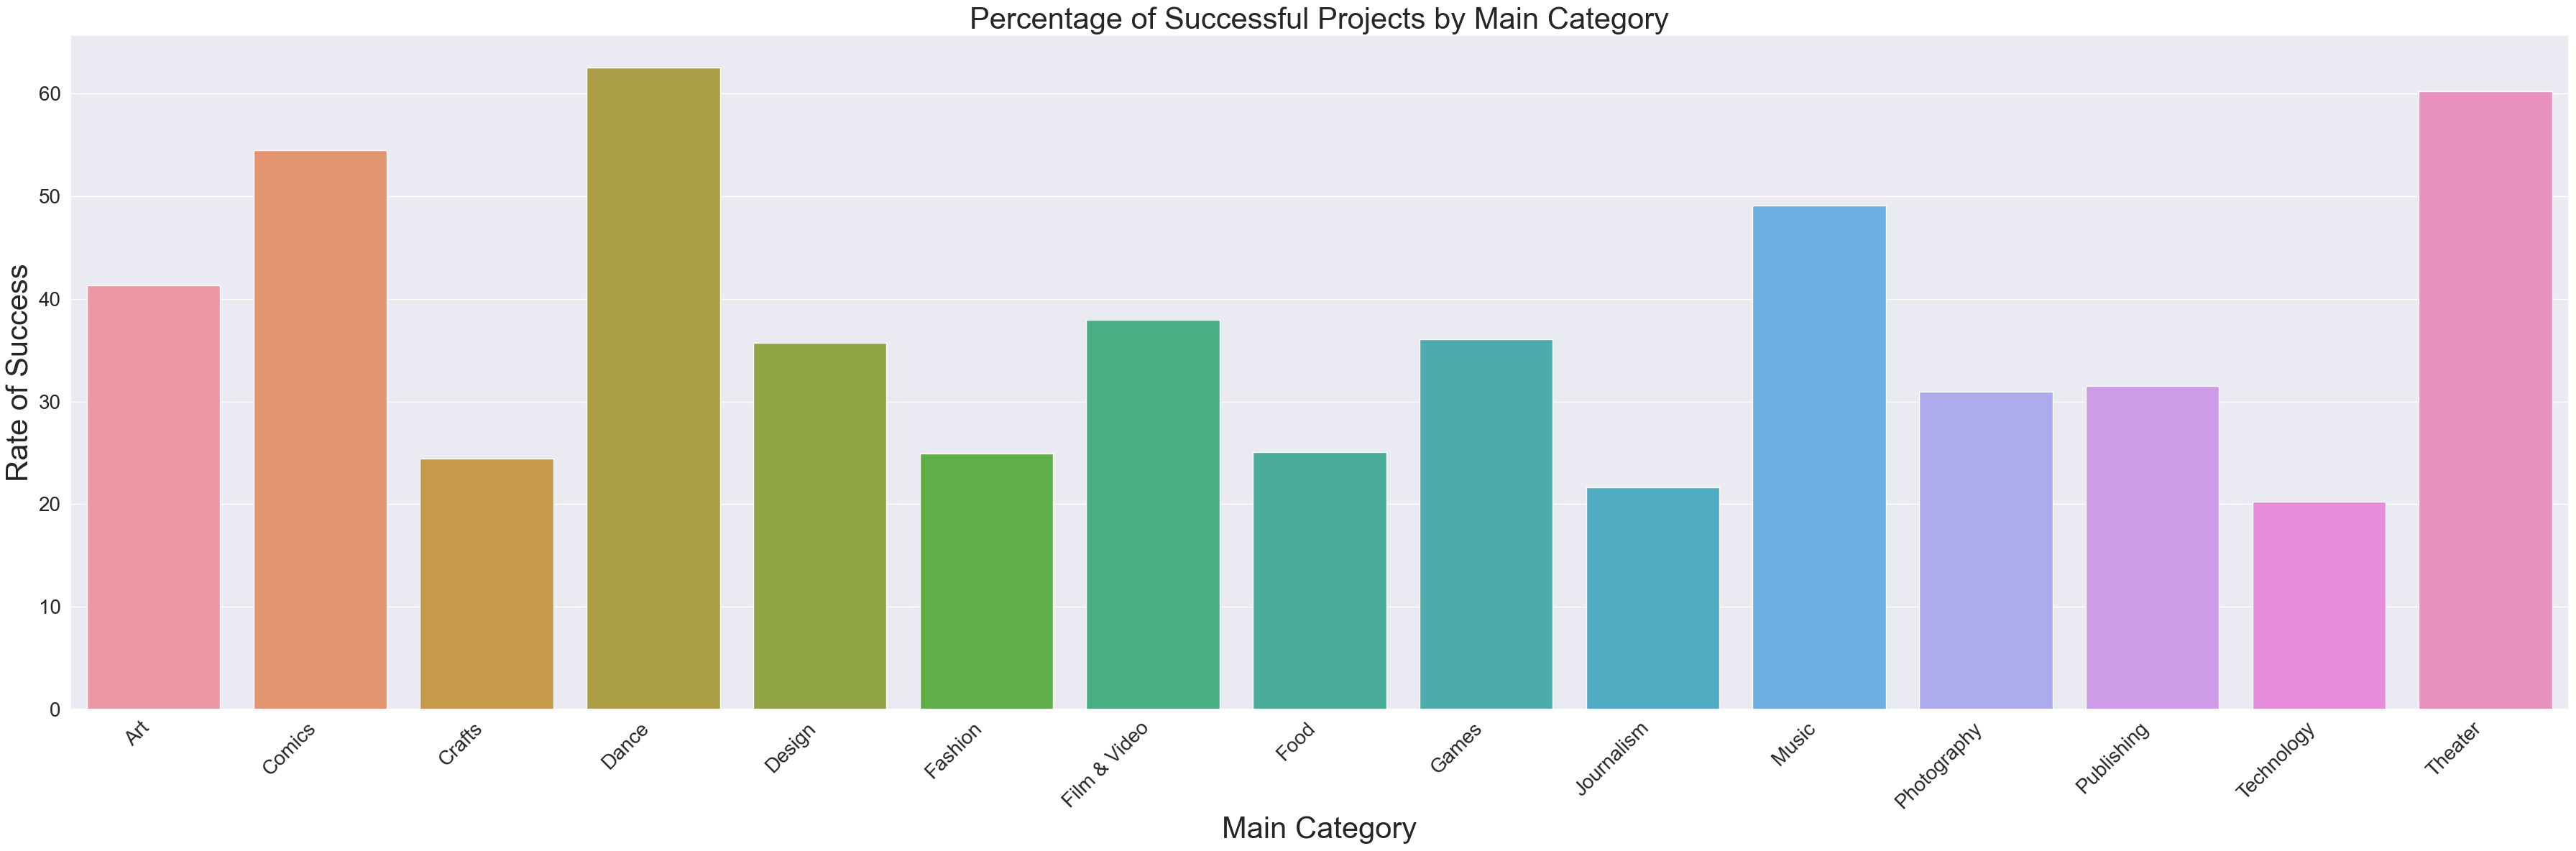

In [8]:
# Percentage of Successful Project by Main Category
successPercentage = (100 * (dfSuccess['main_category'].value_counts() / (df['main_category'].value_counts())))
plt.figure(figsize=(36, 12))
sns.barplot(x=successPercentage.index, y=successPercentage.values)
plt.title('Percentage of Successful Projects by Main Category', fontsize=30)
plt.xlabel('Main Category', fontsize=30)
plt.ylabel('Rate of Success', fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

The only Main Categories that had a greater than 50% success rate were:
1. Comics
2. Dance
3. Theater

Music is an honorable mention, coming in just shy with a 49.09% success rate.

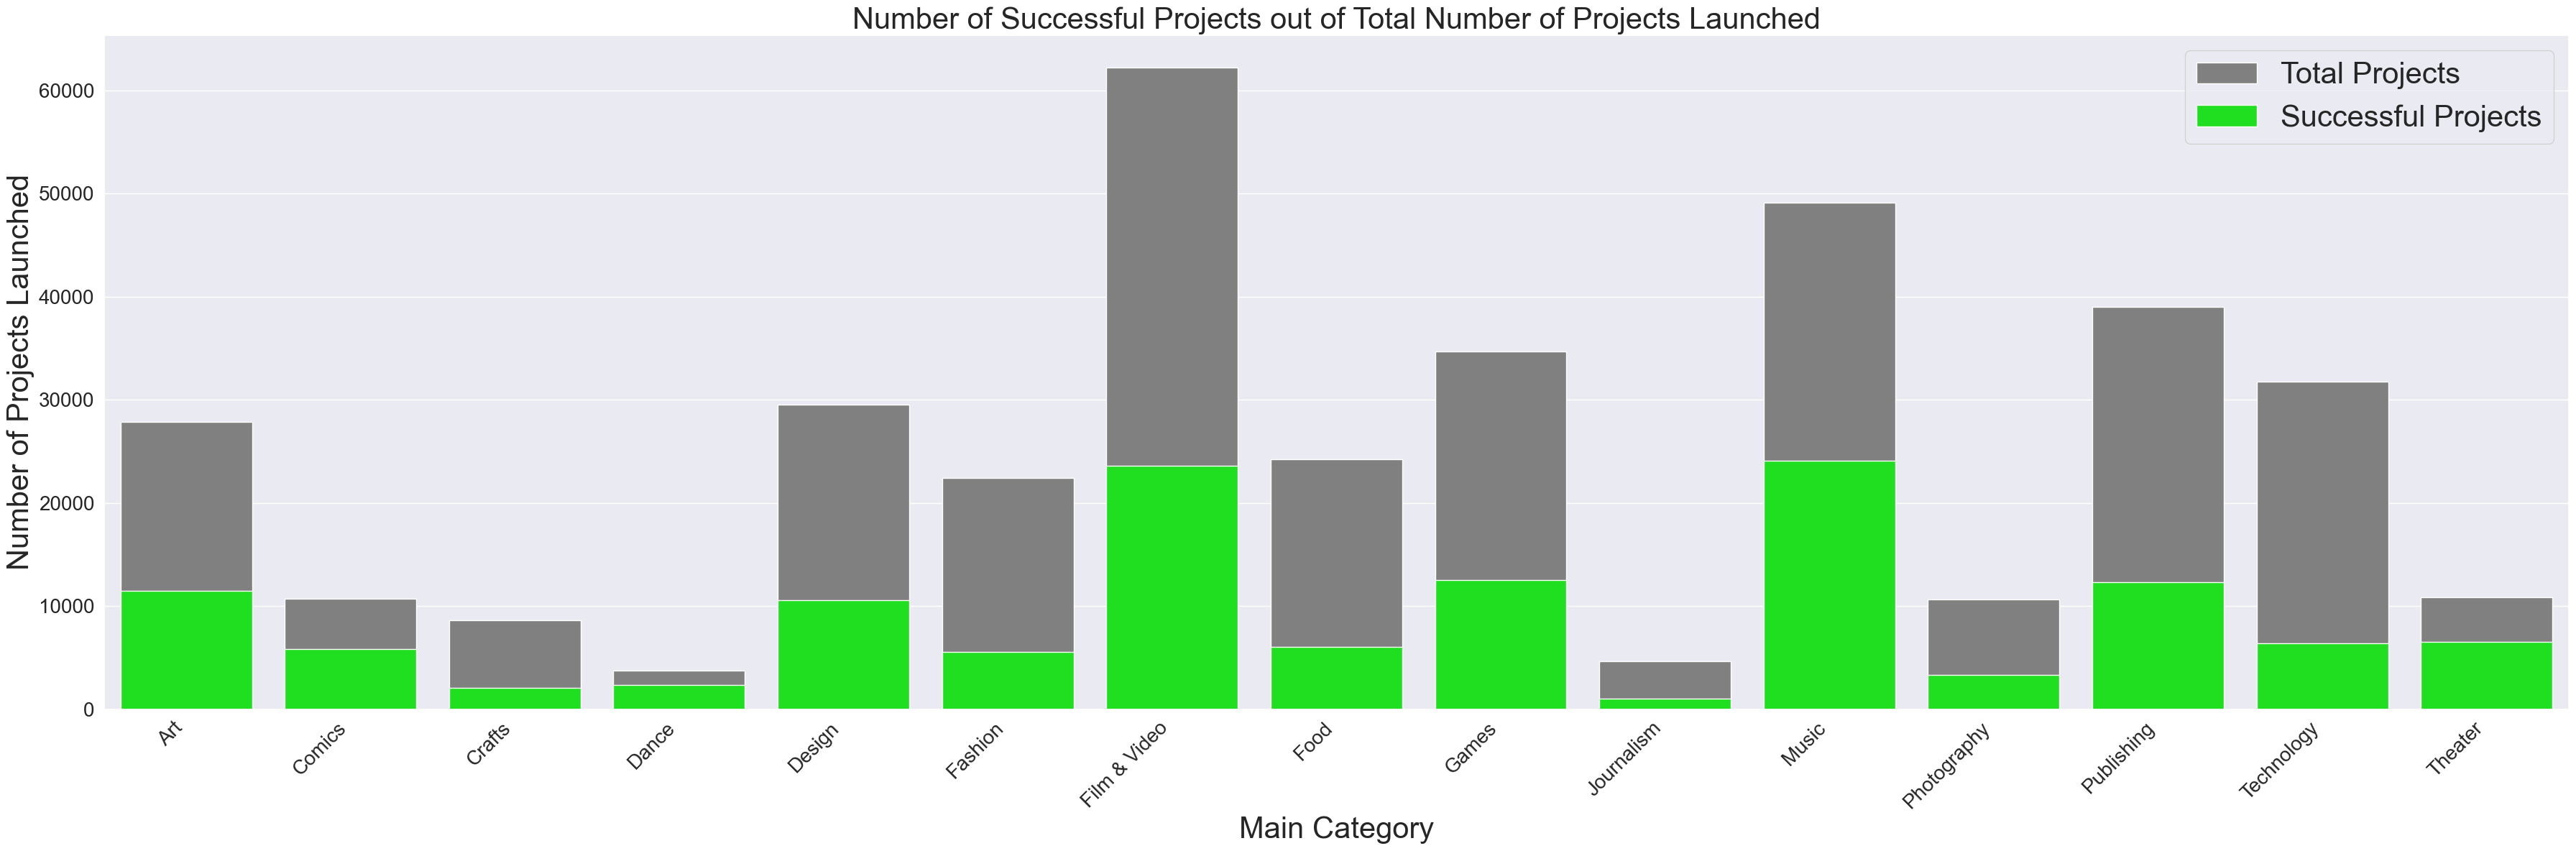

In [9]:
# Number of Successful Projects out of Total Number of Projects Launched
main_category_counts = df['main_category'].value_counts().sort_index()
success_counts =dfSuccess['main_category'].value_counts().sort_index()
plt.figure(figsize=(36, 12))
sns.barplot(x=main_category_counts.index, y=main_category_counts.values, color='gray', label='Total Projects')
sns.barplot(x=success_counts.index, y=success_counts.values, color='lime', label='Successful Projects')
plt.ylabel('Number of Projects Launched', fontsize=30)
plt.title('Number of Successful Projects out of Total Number of Projects Launched', fontsize=30)
plt.xlabel('Main Category', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.legend(fontsize=30)
plt.tight_layout()
plt.show()

By quantifying the number of launched and successful projects by Main Category, we can see that, out of the four previously mentioned Main Categories, Music was the only one that had a relatively large number of projects; the others were generally niche.

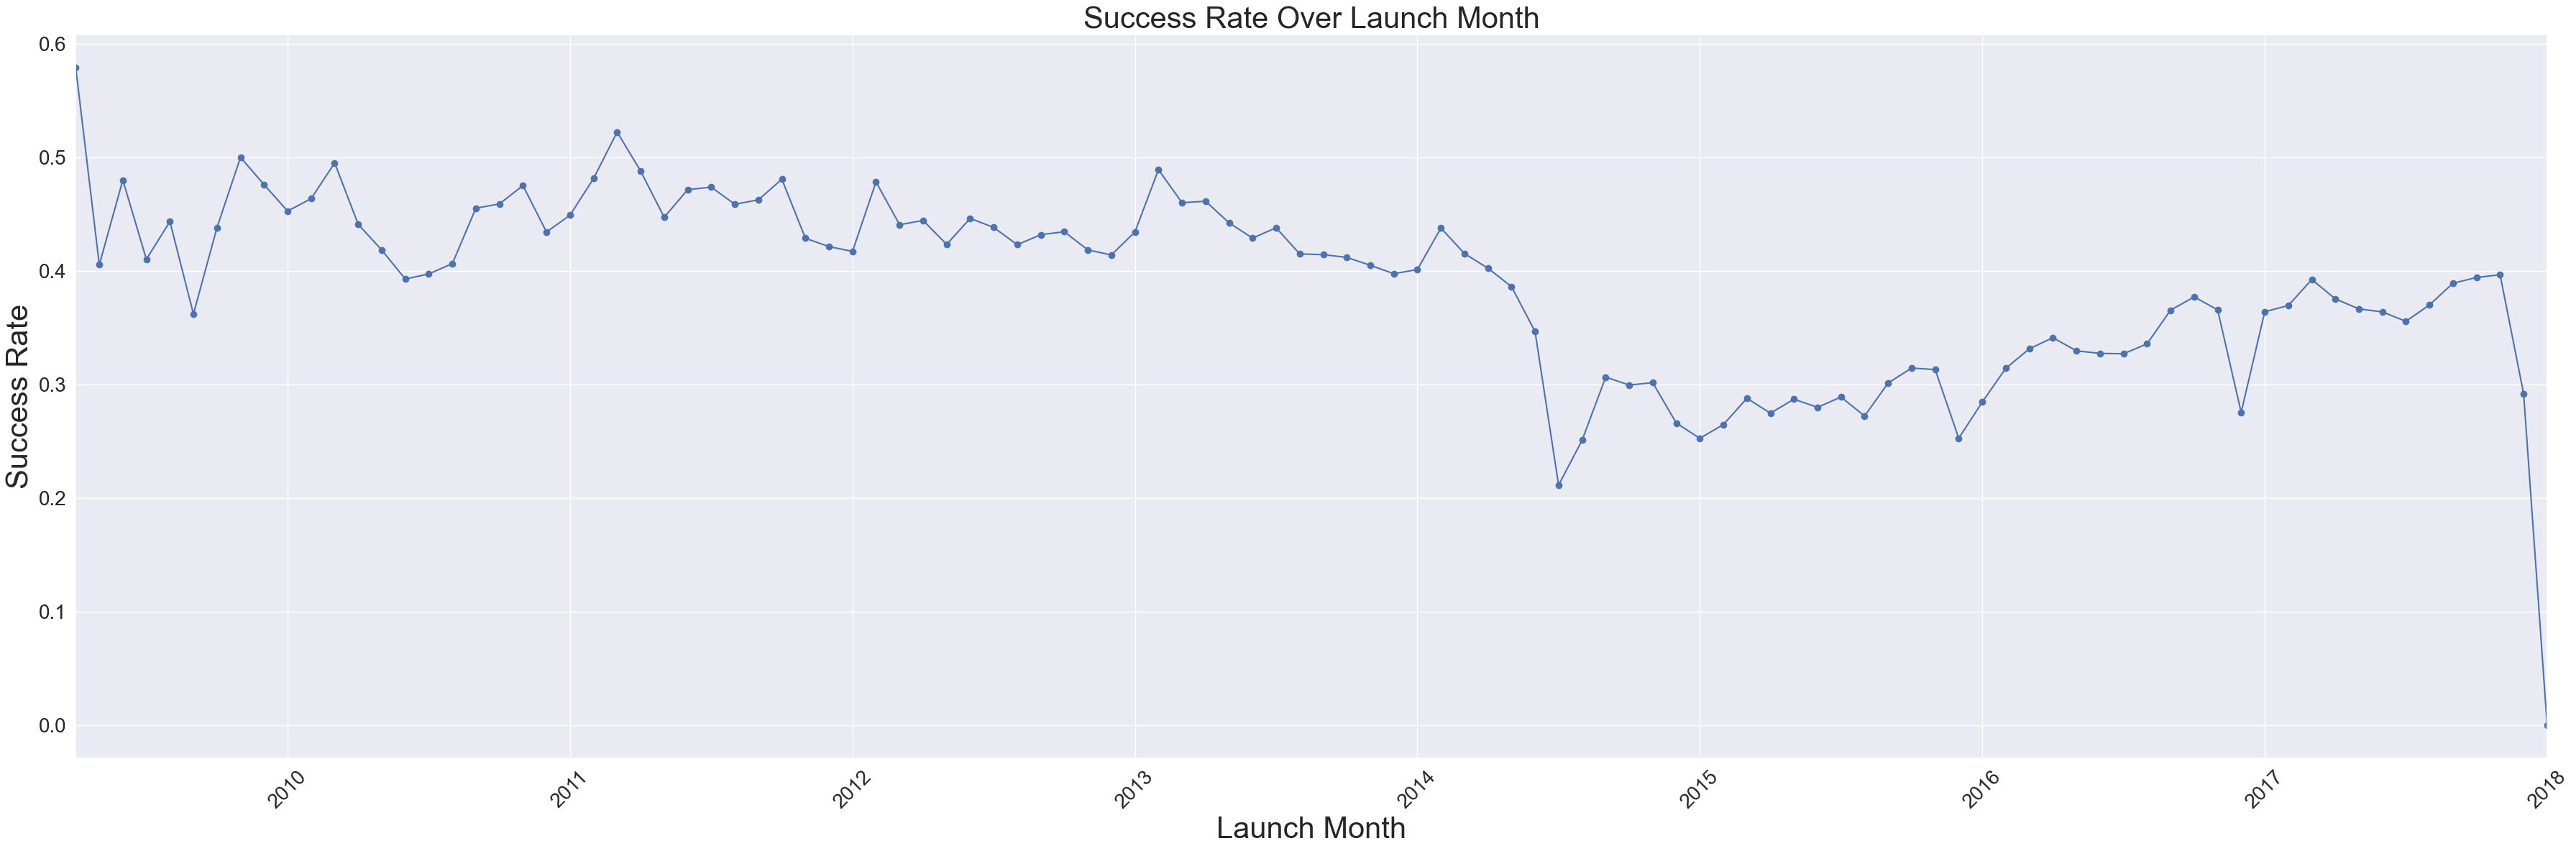

In [10]:
# Success Rate Over Launch Month
df['launched_month'] = pd.to_datetime(df['launched']).dt.to_period('M')
success_rate_by_month = df.groupby(['launched_month', 'state']).size().unstack(fill_value=0)
success_rate_by_month['success_rate'] = success_rate_by_month['successful'] / success_rate_by_month.sum(axis=1)
plt.figure(figsize=(36, 12))
success_rate_by_month['success_rate'].plot(marker='o')
plt.title('Success Rate Over Launch Month', fontsize=30)
plt.xlabel('Launch Month', fontsize=30)
plt.ylabel('Success Rate', fontsize=30)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

Looking at Success Rate Over Launch Month, we noted:
* Average project success rate lingered between 40% - 50% between 2009 - 2014.
* Average project success rate dropped to 25% - 30% halfway through 2014, until 2016.
* Average project success rate rose to 30% - 40% between 2016 - 2018.

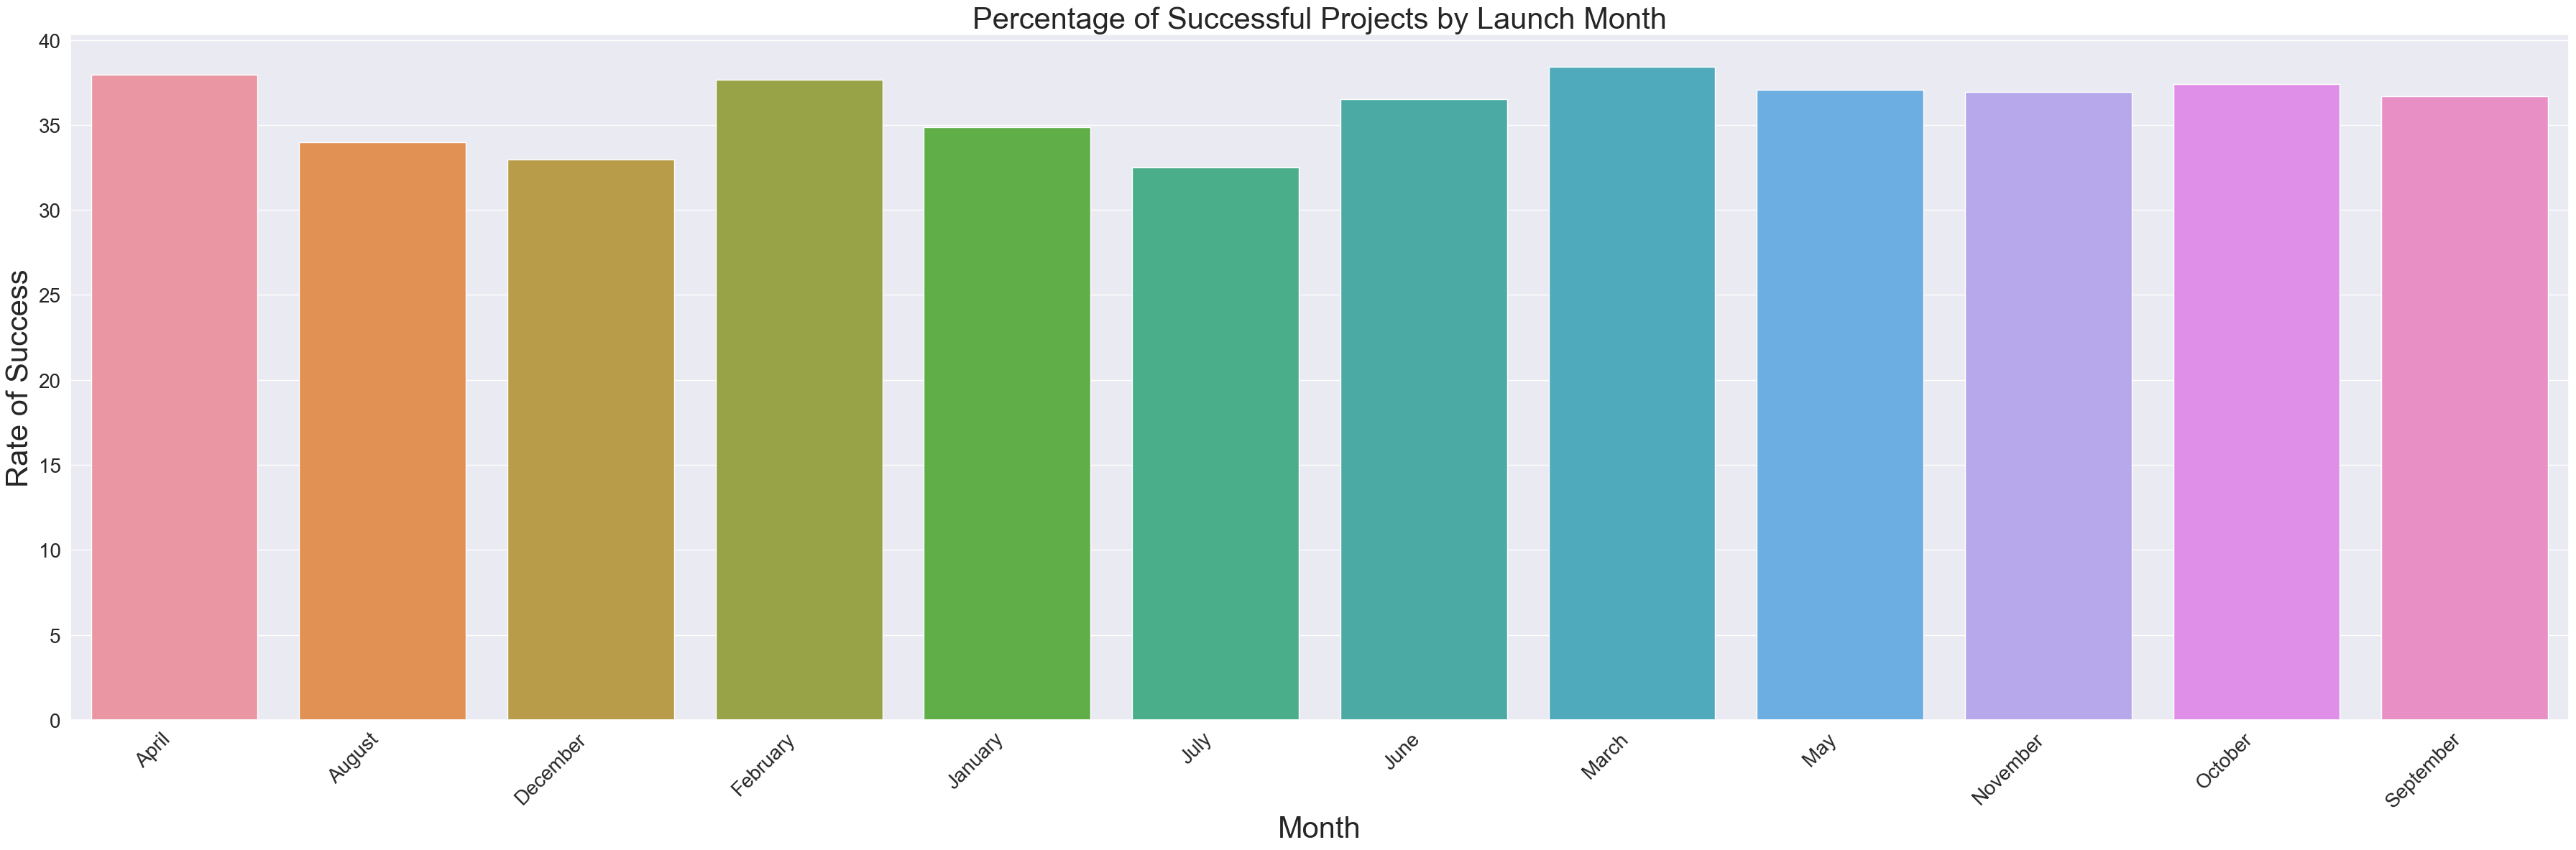

In [11]:
# Percentage of Successful Project by Launch Month
successPercentage = (100 * (dfSuccess['launched'].dt.month_name().value_counts() / (df['launched'].dt.month_name().value_counts())))
plt.figure(figsize=(36, 12))
sns.barplot(x=successPercentage.index, y=successPercentage.values)
plt.title('Percentage of Successful Projects by Launch Month', fontsize=30)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Rate of Success', fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

All launch months have a similar percentage of successful projects, however the exceptionally successful months were February, March, and April.

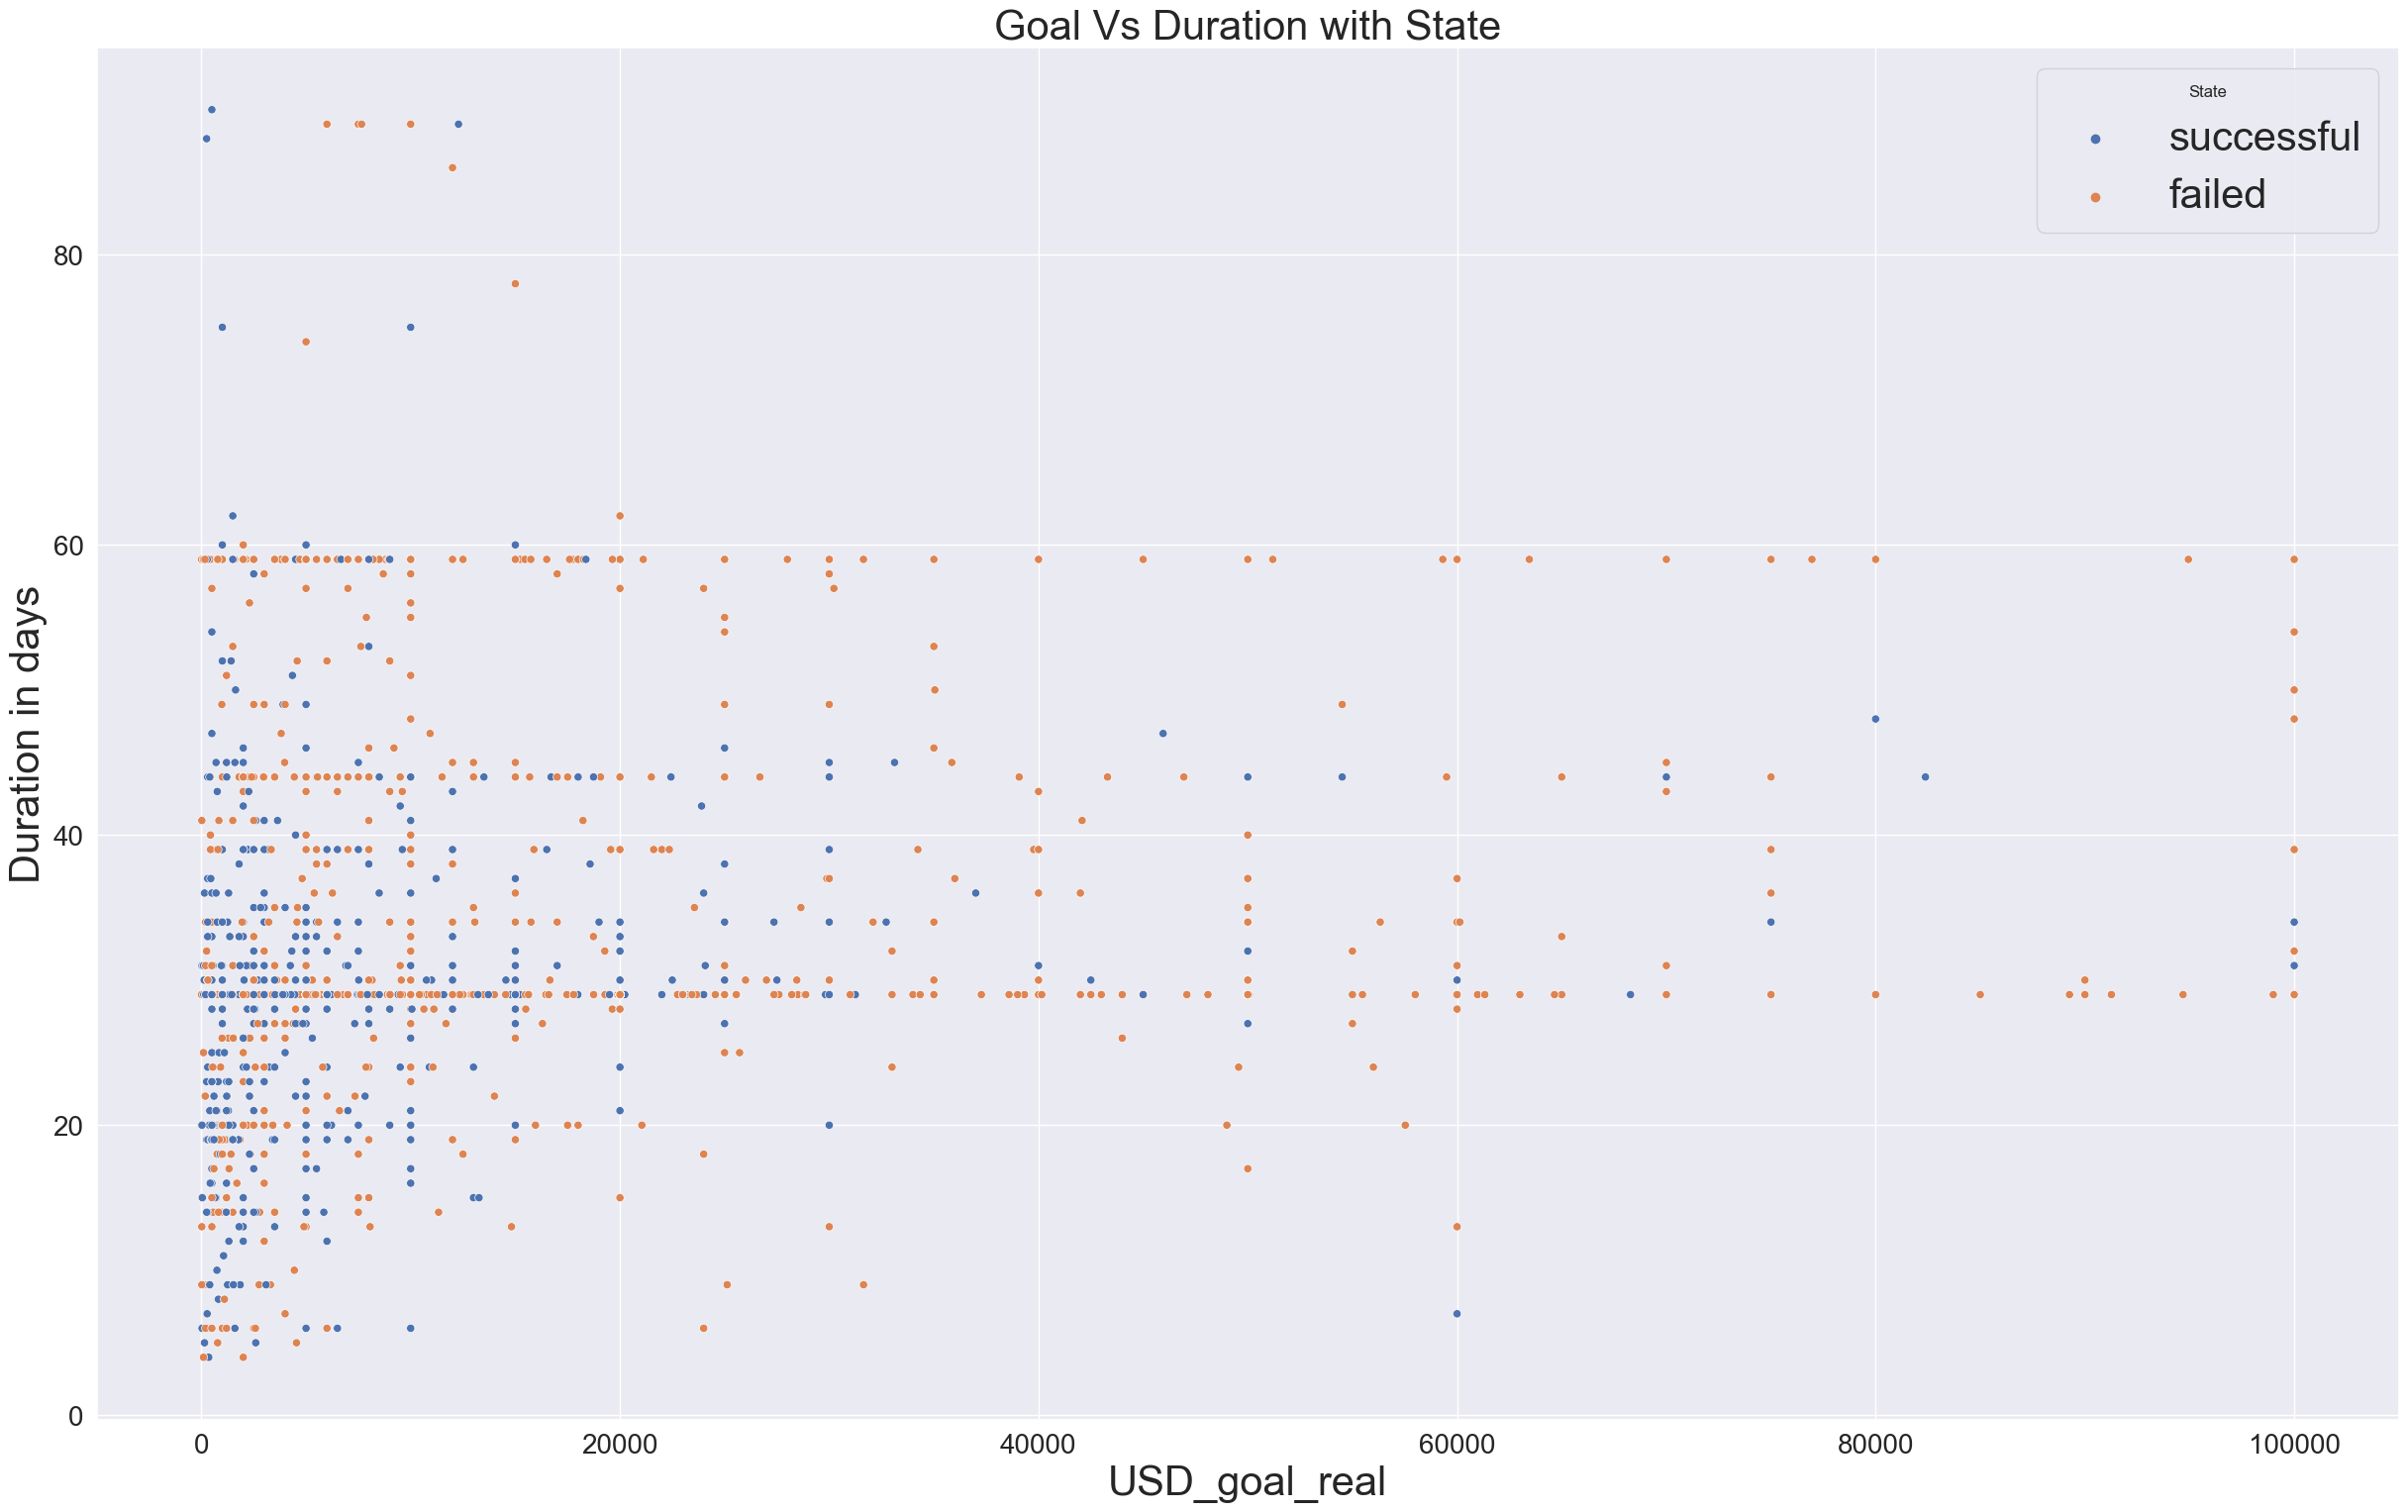

In [35]:
df_scale = df.copy()
df_scale.drop(['category', 'main_category', 'deadline', 'launched', 'country', 'launchedUX', 'deadlineUX', 'stateInt', 'launched_month'], axis = 1)
df_scale = df_scale[df_scale["usd_goal_real"] <= 100000]
df_scale = df_scale.sample(frac=0.005)
plt.figure(figsize=(30, 18))
sns.scatterplot(data=df_scale, x="usd_goal_real", y="duration", hue="state")
plt.xlabel("USD_goal_real", fontsize=30)
plt.ylabel("Duration in days", fontsize=30)
plt.title("Goal Vs Duration with State", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title="State", fontsize=30)
plt.show()

It seems as though the goal doesn't scale with a campaign's deadline, although the majority of successful projects seem to have lower total goals.

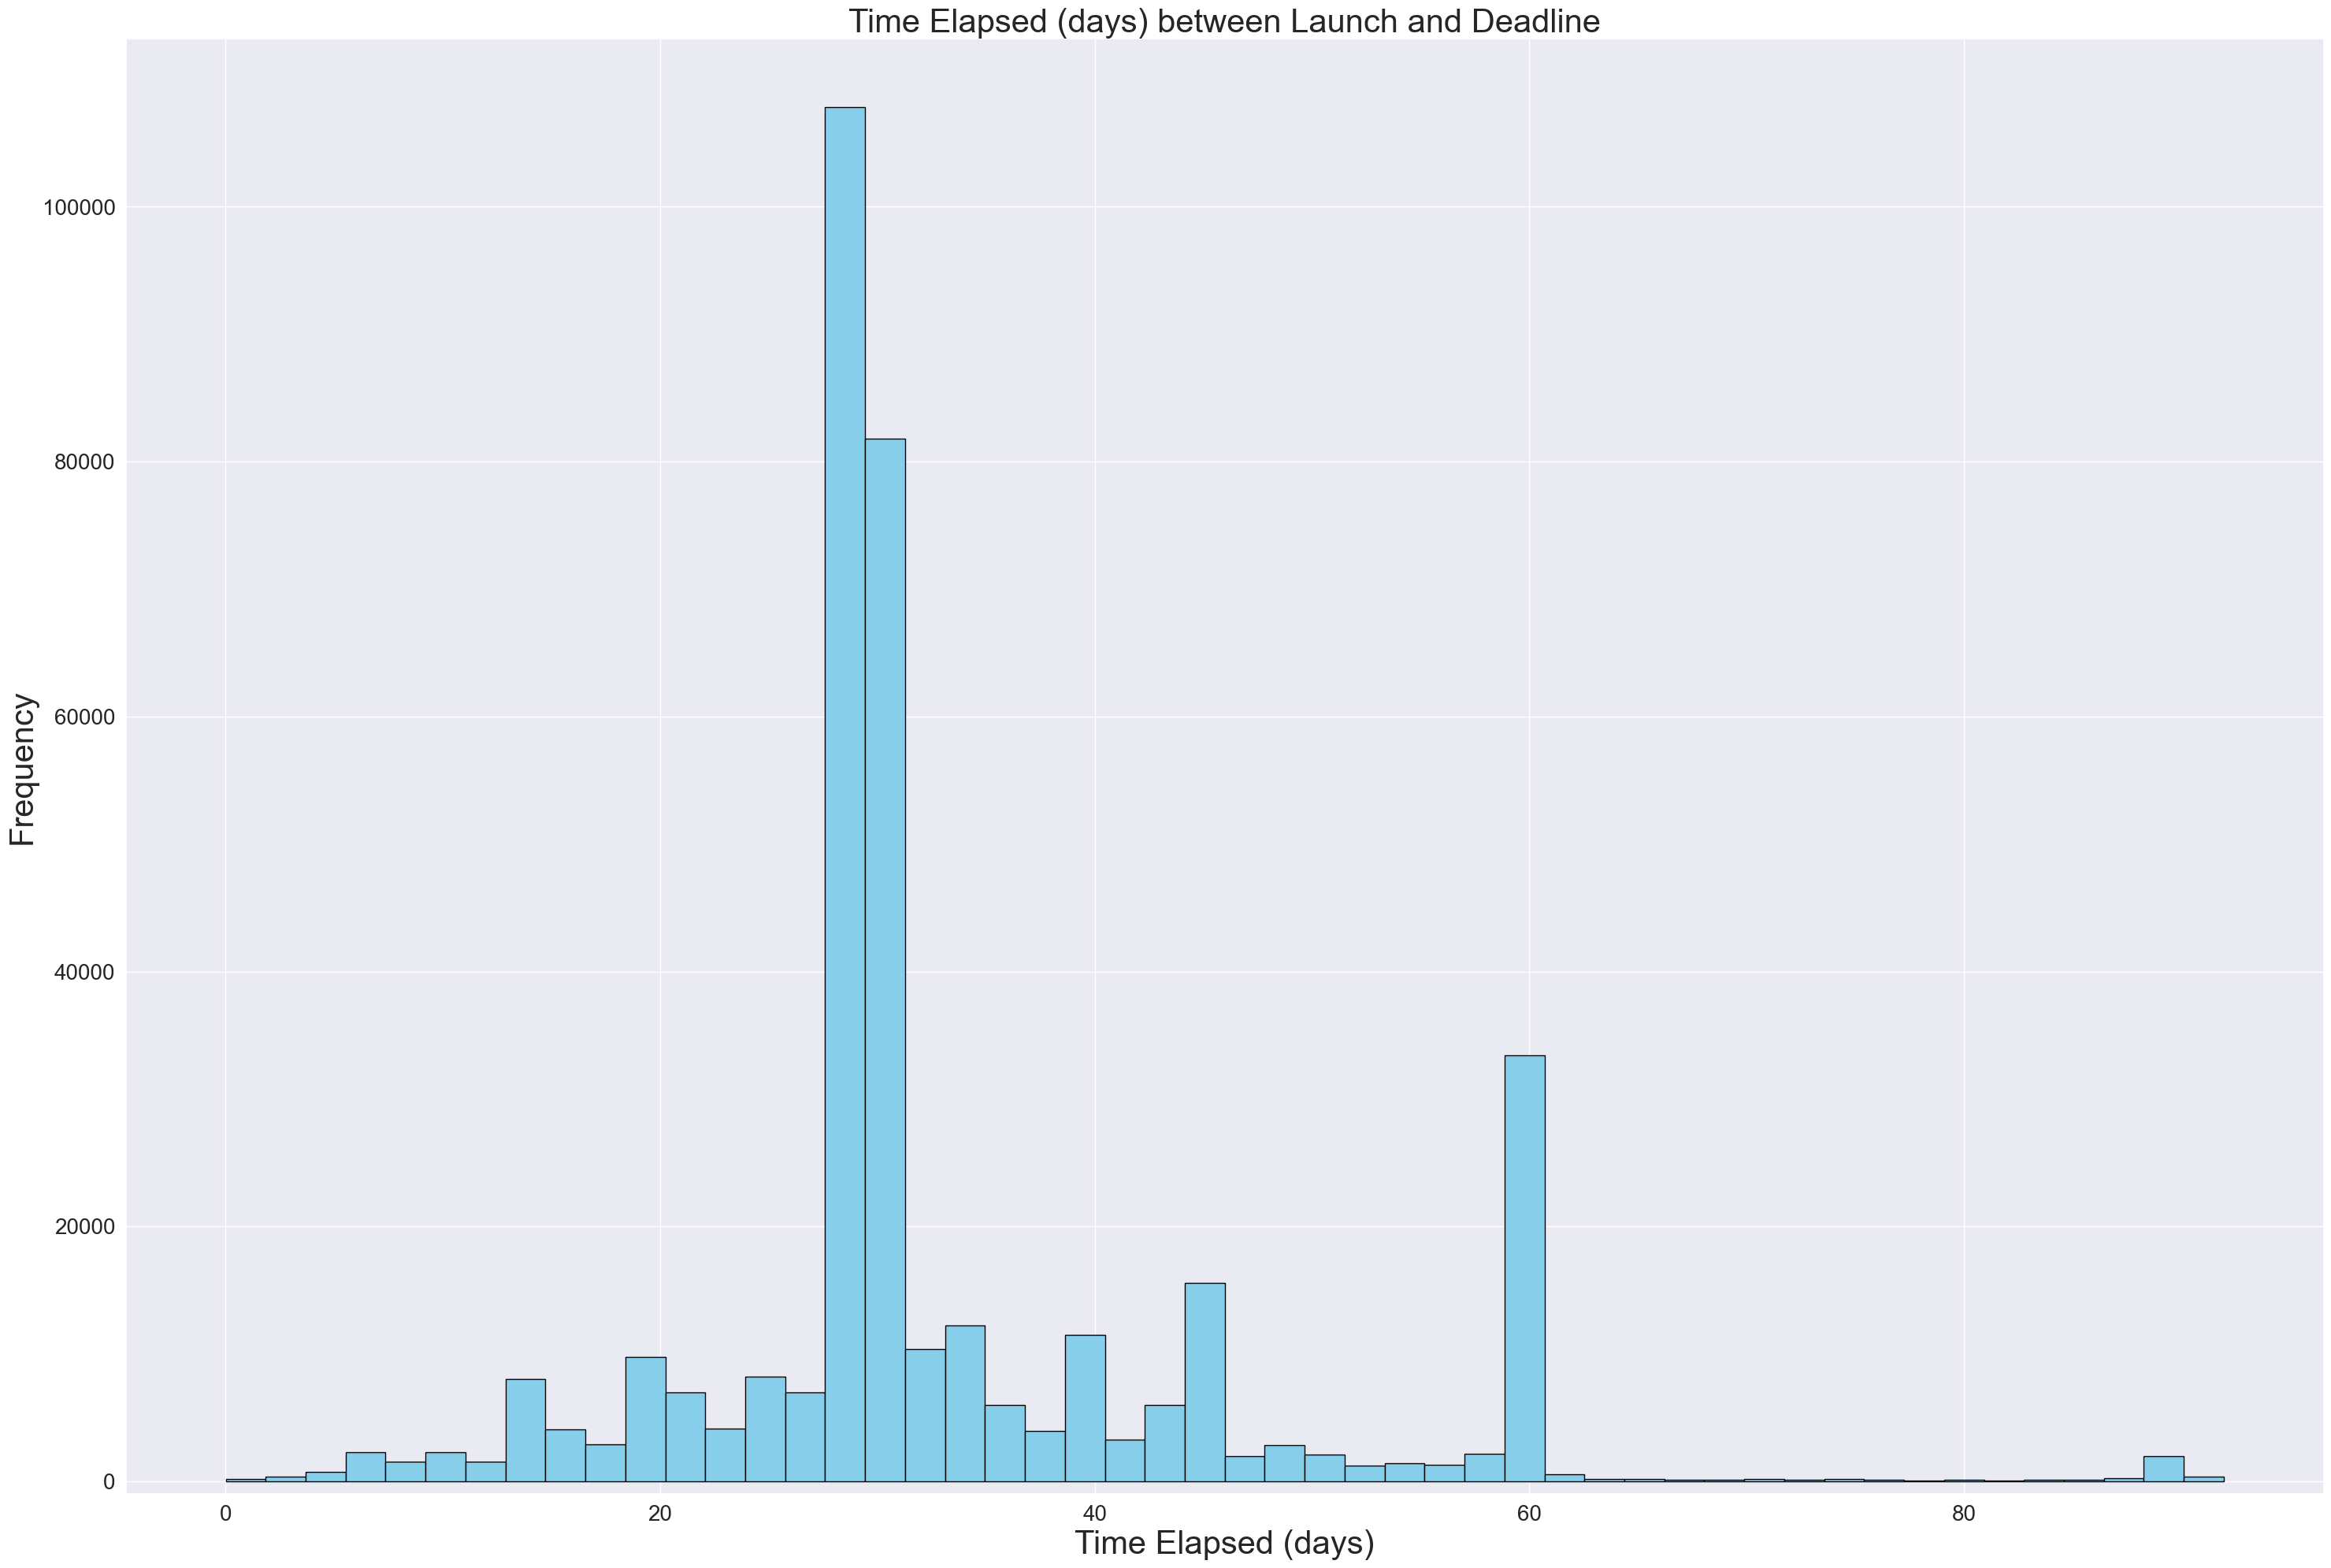

In [13]:
# Time Elapsed (days) between Launch and Deadline
time_elapsed = df['deadlineUX'] - df['launchedUX']
plt.figure(figsize=(36, 24))
plt.hist(time_elapsed, bins=50, color='skyblue', edgecolor='black')
plt.title('Time Elapsed (days) between Launch and Deadline', fontsize=30)
plt.xlabel('Time Elapsed (days)', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(bottom=-1000)
plt.show()

Most campaigns had a launch-to-deadline time of either 30 or 60 days, with almost all campaigns having a launch-to-deadline time between 0 - 60 days.

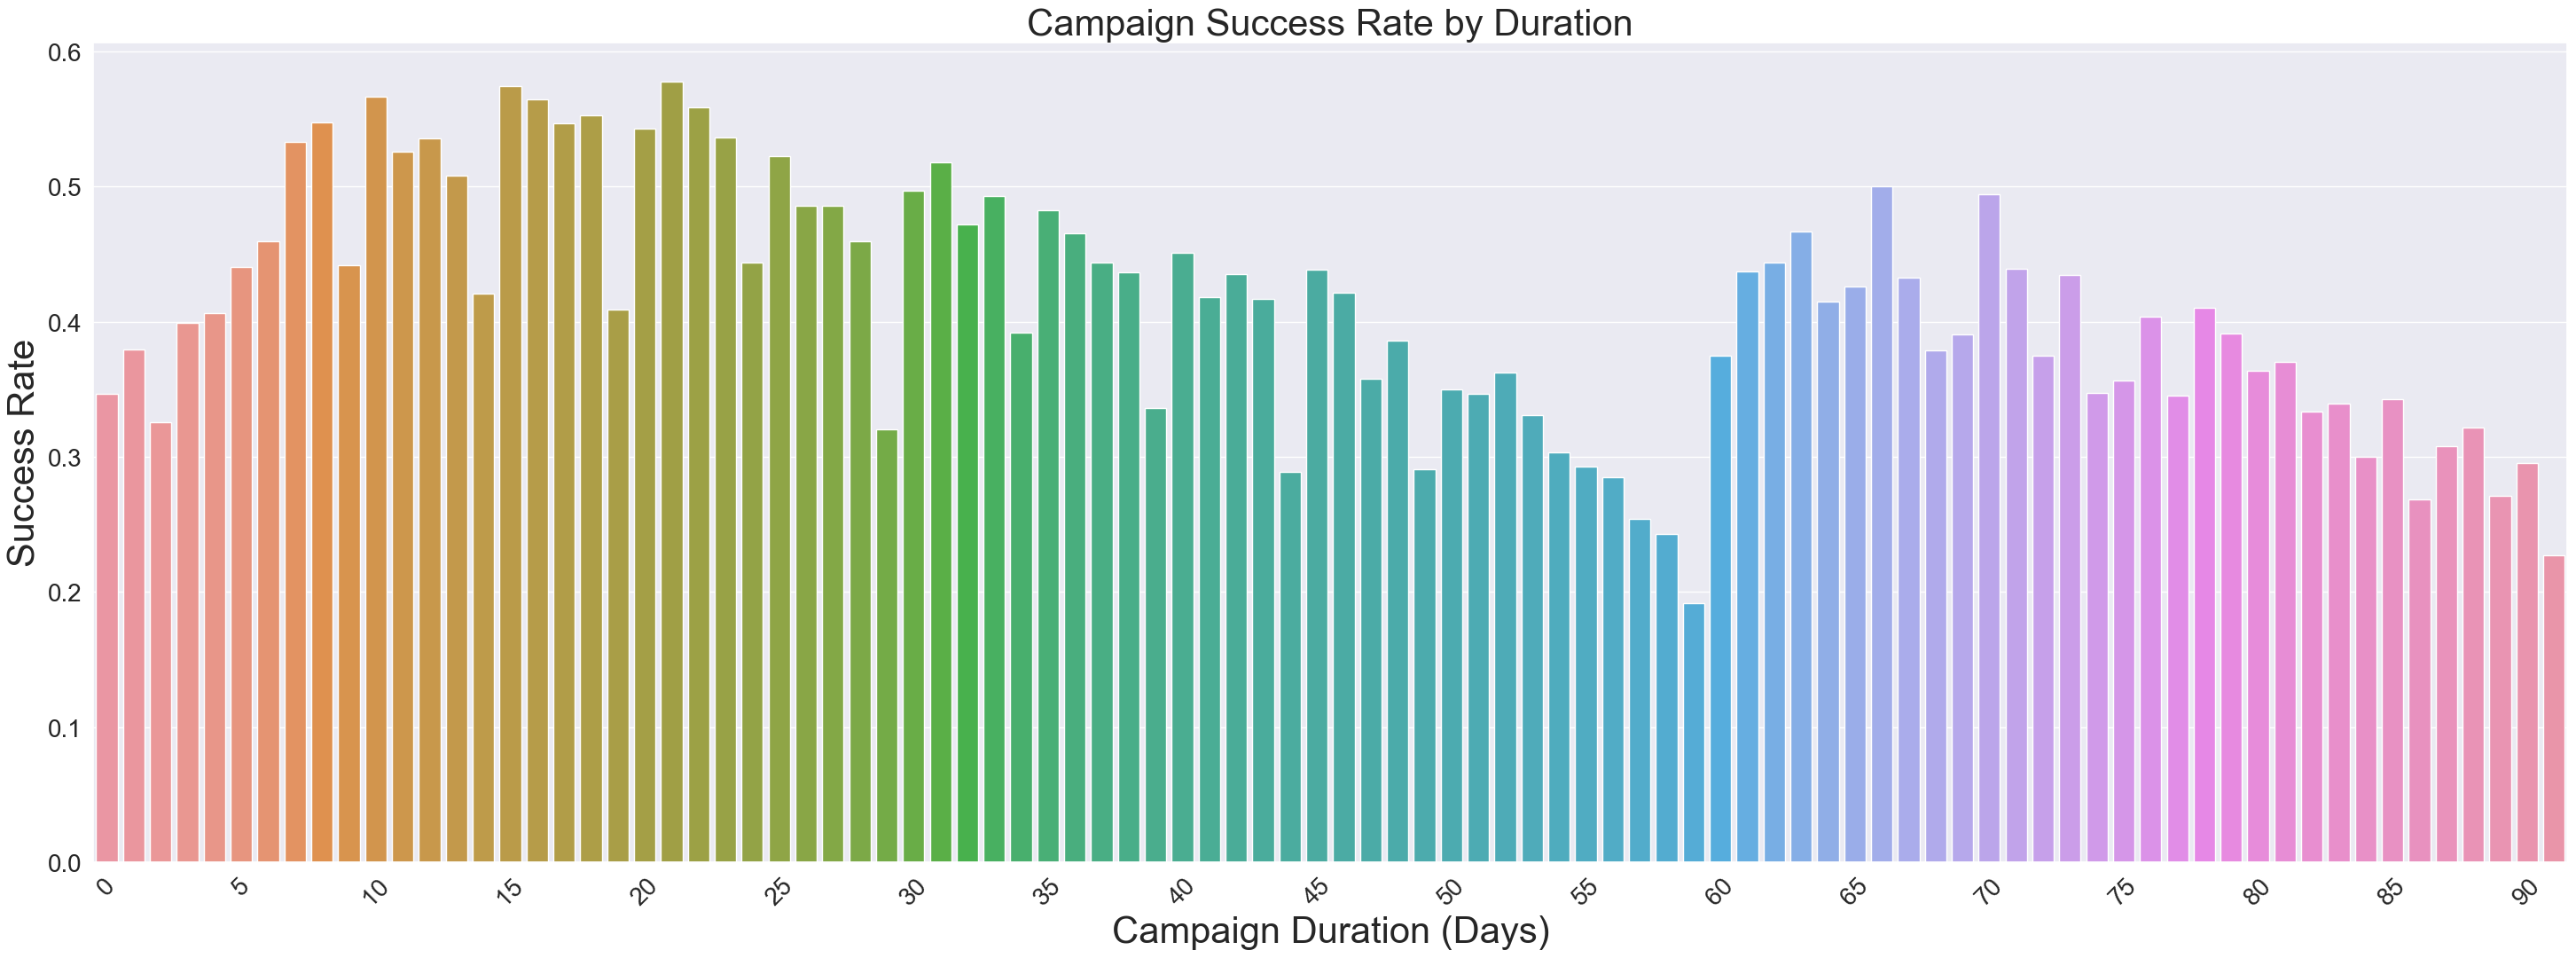

In [14]:
# Campaign Success Rate by Duration (Days)
df_duration_state_counts = df.groupby("duration")["state"].value_counts()

def calc_success_rate_by_duration_days(x):
    duration_days = x.index[0][0]
    successful_count = x.loc[(duration_days, "successful")]
    failed_count = x.loc[(duration_days, "failed")]
    return successful_count / (successful_count + failed_count)


df_success_rate_by_duration_days = df_duration_state_counts.groupby(level=0).apply(calc_success_rate_by_duration_days)

plt.figure(figsize=(36,12))
success_rate_by_duration_days = sns.barplot(
    x=df_success_rate_by_duration_days.index,
    y=df_success_rate_by_duration_days
)

success_rate_by_duration_days.set_title("Campaign Success Rate by Duration", size=30)
success_rate_by_duration_days.set_xlabel("Campaign Duration (Days)", size=30)
success_rate_by_duration_days.set_ylabel("Success Rate", size=30)
success_rate_by_duration_days.xaxis.set_major_locator(plt.MultipleLocator(5))
success_rate_by_duration_days.tick_params(axis="x", labelsize=20, rotation=45)
success_rate_by_duration_days.tick_params(axis="y", labelsize=20)

It appears that campaign success rate gradually declined from about 60% to about 30% for campaigns with durations between 0 to 60 days.

It then picked back up for a gradual decline from about 50% to about 30% for campaigns with a duration between 60 to 90 days.

Outliers were campaign durations of 30 and 60 days. This can be explained by referring to the previous visualization, wherein we discovered that almost all campaigns launched had a launch-to-deadline time of either 30 or 60 days.

# Machine Learning
Considering our goal is to classify Kickstarter projects as "success" or "failed" using our machine learning analysis, we chose to utilize primarily Decision Trees while also testing with KNeighbor Classfication strategies. 

## Selecting our parameters
* Decision Tree: In order to select the best argument values for our Decision Tree algorithm, we chose to run a looped training routine that utilized the ``cross_val_score`` function. For each run we altered which argument we were testing while applying the previously determined best values for any remaining arguments. This was then repeated for each argument in order to get an optimal output. This form of serially testing argument values was chosen instead of running every combination of argument values together in a single loop in order to save on computation time.
* KNeighbor Classification: The primary arguments we could change with this classification algorithm were the selection of features, and the neighbor value. For the neighbor value we settled on the square root of the dataset's sample size, which is a known general rule of thumb. For determining the classification algorithm's feature set we utilized the same combination testing algorithm that was used with determining the Decision Trees feature set.

## Decision Tree Optimal Parameters Loop Ranges
* features - All combinations of ``[category, main_category, country, usd_goal_real, duration, launchedUX, deadlineUX]``
* ``max_depth`` - Range from ``1`` to ``20`` with increments of ``1``.
* ``min_samples_split`` - Range from ``2`` to ``150`` with increments of ``5`` - loop was repeated with a smaller subset of values after other arguments were selected.
* ``min_samples_leaf`` - Range from ``1`` to ``100`` with increments of ``5`` - loop was repeated with a smaller subset of values after other arguments were selected.
* ``min_impurity_decrease`` - Range from ``0.0`` to ``0.5`` with increments of ``0.1``.

## Model 1 - kNN

Accuracy of Training Data: 0.6810816859668687
Accuracy of Testing Data: 0.6807725205960473
elasped: 428.88458275794983
                   Actual                    
    Predict        Failed         Success    
    Failed          61568          9303      
    Success         26152          14042     


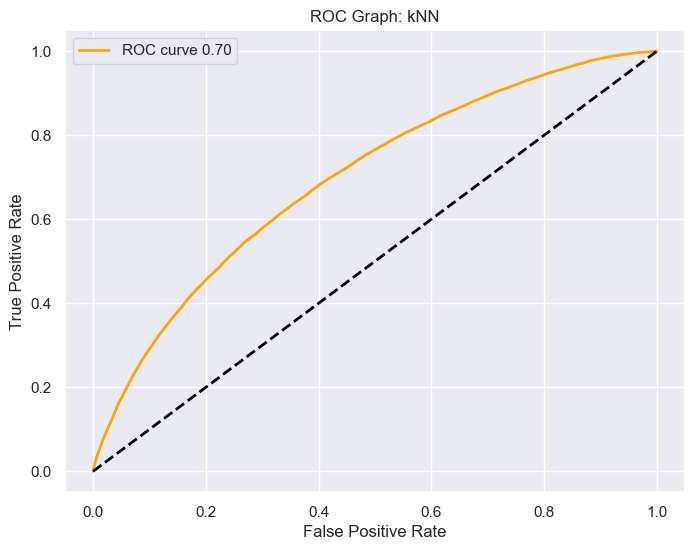

In [15]:
start = time.time()

x = pd.concat([cat_dummies, main_cat_dummies, country_dummies, clas_df[["usd_goal_real"]], clas_df[["duration"]], clas_df[["launchedUX"]]], axis=1)
y = clas_df["stateInt"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k = int(np.sqrt(X_train.shape[0])) # General rule is that k should be sqrt(N), where N is the number of samples in the dataset
clas = KNeighborsClassifier(n_neighbors=k)
clas.fit(X_train, y_train)
y_predict_test = clas.predict(X_test)
y_predict_train = clas.predict(X_train)

print("Accuracy of Training Data: {}".format(print_percent_correct(y_train, y_predict_train)))
print("Accuracy of Testing Data: {}".format(print_percent_correct(y_test, y_predict_test)))
print("elasped: {}".format(time.time() - start))

print_conf_matrix(y_test, y_predict_test, ["Failed", "Success"])
roc_plot(X_test, "kNN", clas)

It appears that even a simple classification algorithm such as kNN, given a large enough ``k`` value, is able to sufficiently generalize from the training data to produce a model with an accuracy of approximately 68%.

## Model 2 - Decision Tree

Accuracy of Training Data: 0.7040605670053367
Accuracy of Testing Data: 0.6947823346688876
elasped: 7.052471160888672
                   Actual                    
    Predict        Failed         Success    
    Failed          59195          11676     
    Success         22223          17971     


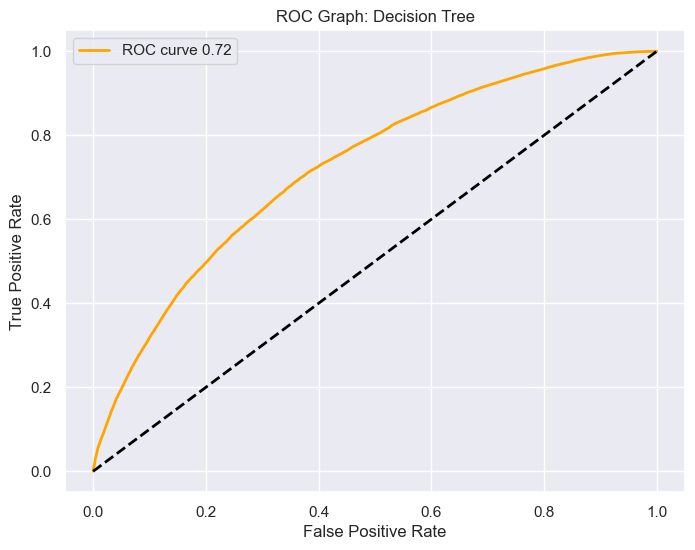

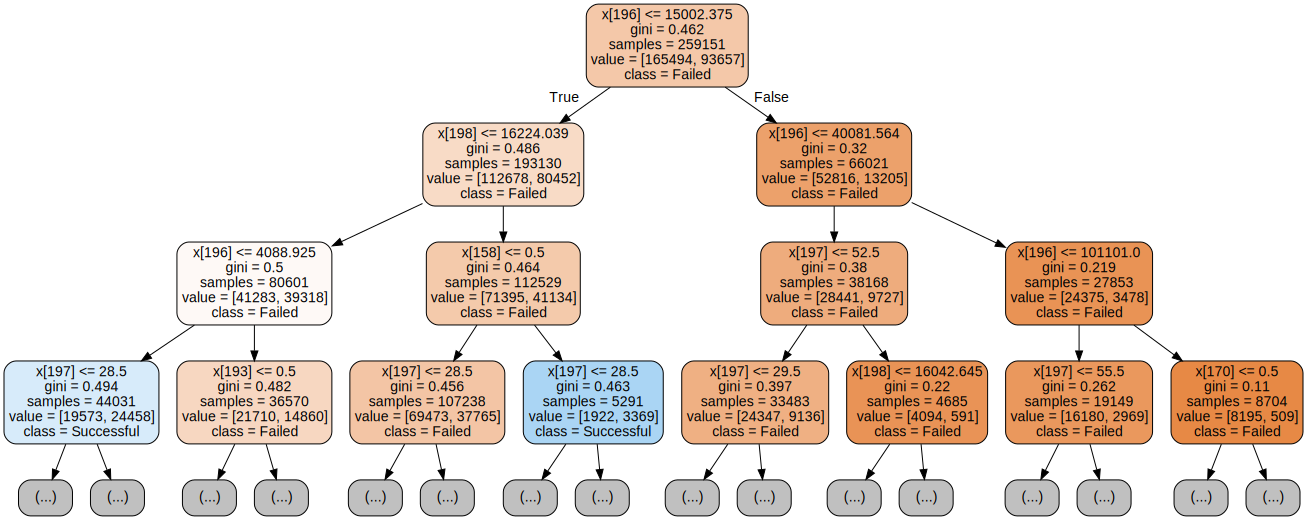

In [31]:
# Best Results

# Category
# Duration
# LaunchedUX
# Main_Category
# Country
# usd_goal_real

# Depth
# 16

# min_samples_split
# 2

# min_samples_leaf
# 83

# min_impurity_decrease
# 0.0

# Final Maximum Accuracy = 0.6947823346688876

features = [country_dummies, cat_dummies, main_cat_dummies, clas_df[["usd_goal_real"]], clas_df[["duration"]], clas_df[["launchedUX"]], clas_df[["deadlineUX"]]]
all_combinations = []

for r in range(len(features) + 1):
    for combination in itertools.combinations(features, r):
        if len(combination) != 0:
            all_combinations.append(combination)

best_max_depth = 16
best_min_samples_split = 2
best_min_samples_leaf = 83
best_min_impurity_decrease = 0.0
best_permutation = []

max_depth_range = range(1, 20, 1)
min_samples_split_range = range(2, 150, 5)
min_samples_leaf_range = range(1, 100, 5)
impurity_decrease_range = [i * 0.1 for i in range(0, 6)]

score_board = []
index = 0

start = time.time()

#for i in ("Insert argument range such as "max_depth_range"):
#print("elasped: {}".format(time.time() - start))

#index += 1
#print("Index {}".format(index))

x = pd.concat([country_dummies, cat_dummies, main_cat_dummies, clas_df[["usd_goal_real"]], clas_df[["duration"]], clas_df[["launchedUX"]]], axis=1)
y = clas_df["stateInt"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state=42)
clf = DecisionTreeClassifier(max_depth = best_max_depth, min_samples_split = best_min_samples_split, min_samples_leaf = best_min_samples_leaf, min_impurity_decrease = best_min_impurity_decrease, random_state = 20)

clf.fit(X_train, y_train)
y_predict_train = clf.predict(X_train)
y_predict_test = clf.predict(X_test)

print("Accuracy of Training Data: {}".format(print_percent_correct(y_train, y_predict_train)))
print("Accuracy of Testing Data: {}".format(print_percent_correct(y_test, y_predict_test)))
print("elasped: {}".format(time.time() - start))

# Confusion Matrix
print_conf_matrix(y_test, y_predict_test, ["Failed", "Success"])

# Used when trying to validate the best values for targeted arguments
#scores = cross_val_score(estimator=clf, X=x, y=y, cv = 5, n_jobs=-1)
#score_board.append((i, scores.mean()))

# Used when comparing accuracy from cross validation.
"""max_score = 0.0
for x in score_board:
    if (x[1] > max_score):
        max_score = x[1]
        best_permutation = x[0]""";

roc_plot(X_test, "Decision Tree", clf)

dot = export_graphviz(clf, filled=True, rounded=True, class_names=["Failed", "Successful"], max_depth=3)
graph = graphviz.Source(dot)
graph